### Python packages
To read GOES-16 data you will need the netCDF4 package. To manipulate and plot the data we recommend matplotlib & numpy.

In [1]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Reading in Level 1b GOES-16 NetCDF
Here we will open the dataset and read in the radiance variable, called 'Rad' in the file.

In [2]:
g16nc = Dataset('OR_ABI-L1b-RadM1-M3C02_G16_s20171931811268_e20171931811326_c20171931811356.nc', 'r')
radiance = g16nc.variables['Rad'][:]
g16nc.close()
g16nc = None

### Initial Radiance Plot
Lets plot the data first just to see what we are working with here

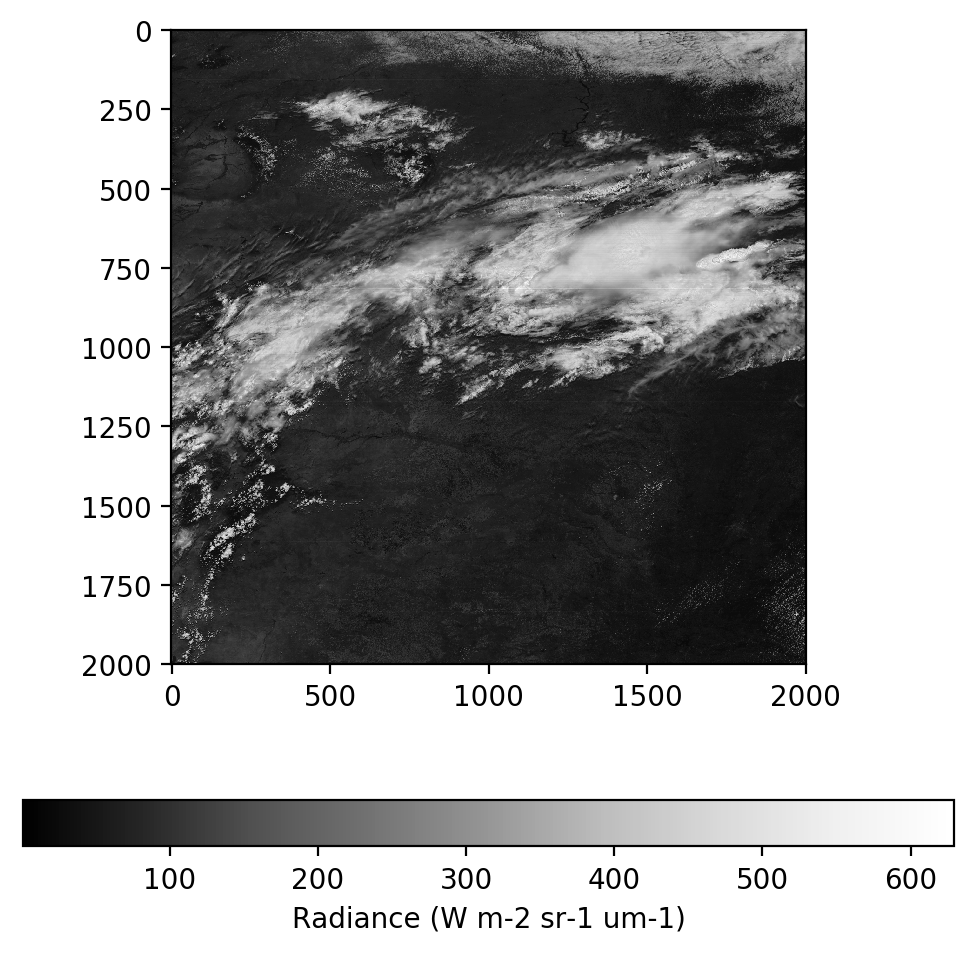

In [3]:
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(radiance, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.show()

### Radiance to Reflectance
It is useful to convert the radiance values from an absolute scale into a relative scale to make them easier to deal with in the following steps. We will use the example formula published by NOAA at [http://www.goes-r.gov/products/ATBDs/baseline/Imagery_v2.0_no_color.pdf](http://www.goes-r.gov/products/ATBDs/baseline/Imagery_v2.0_no_color.pdf) on page 21.

In [4]:
# Define some constants needed for the conversion. From the pdf linked above
Esun_Ch_02 = 663.274497
d2 = 0.3

In [5]:
# Apply the formula to convert radiance to reflectance
ref = (radiance * np.pi * d2) / Esun_Ch_02

# Make sure all data is in the valid data range
ref = np.maximum(ref, 0.0)
ref = np.minimum(ref, 1.0)

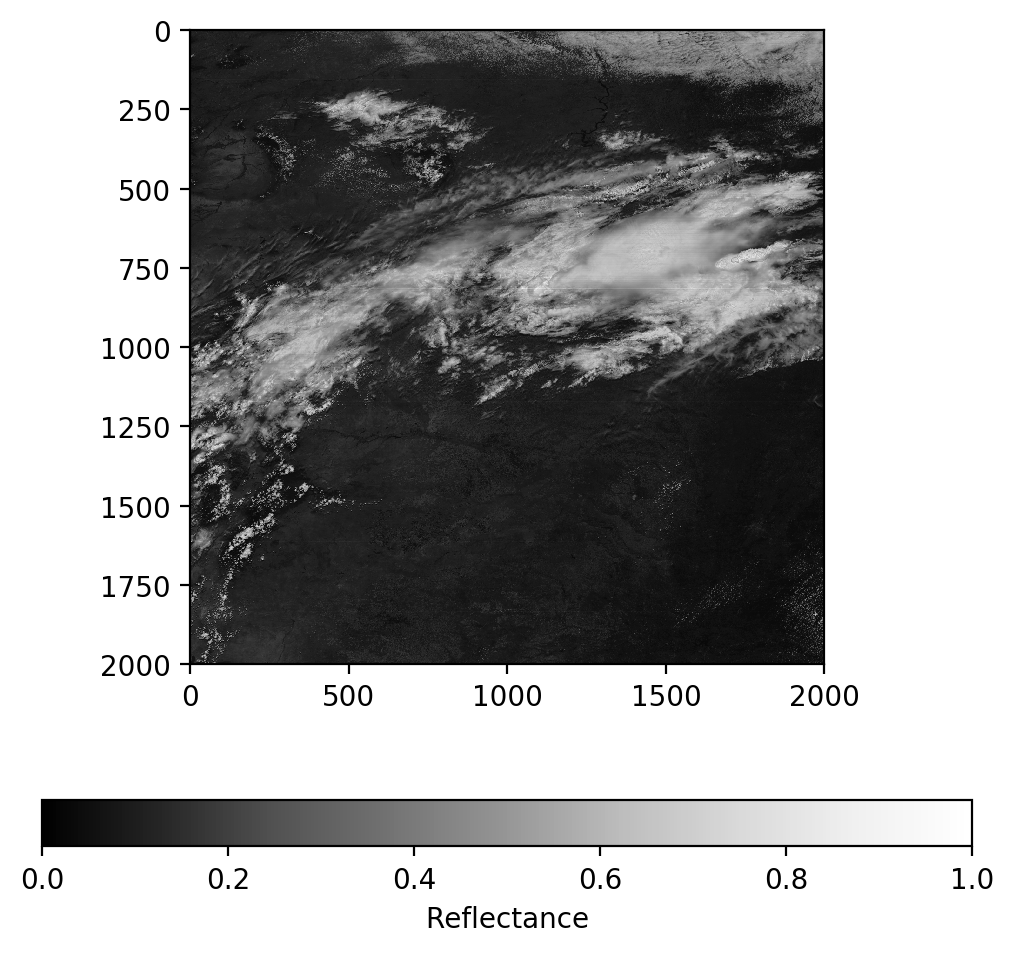

In [6]:
# Plot reflectance
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(ref, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Reflectance')
plt.show()

### Reading in Level 2 GOES NetCDF Data
So the Level 1b data contains radiance values, and we just demonstrated the process to convert this data to reflectance. However, lets say you just want to get straight to the good stuff and not go through this process? Thankfully, NOAA provides the reflectance & brightness temperatures precomputed as the Level 2 product. We will work with those from here on out.

In [7]:
# Read in Level 2 NetCDF
g16nc = Dataset('OR_ABI-L2-CMIPM1-M3C02_G16_s20171931811268_e20171931811326_c20171931811393.nc', 'r')
ref_ch2 = g16nc.variables['CMI'][:]
g16nc.close()
g16nc = None

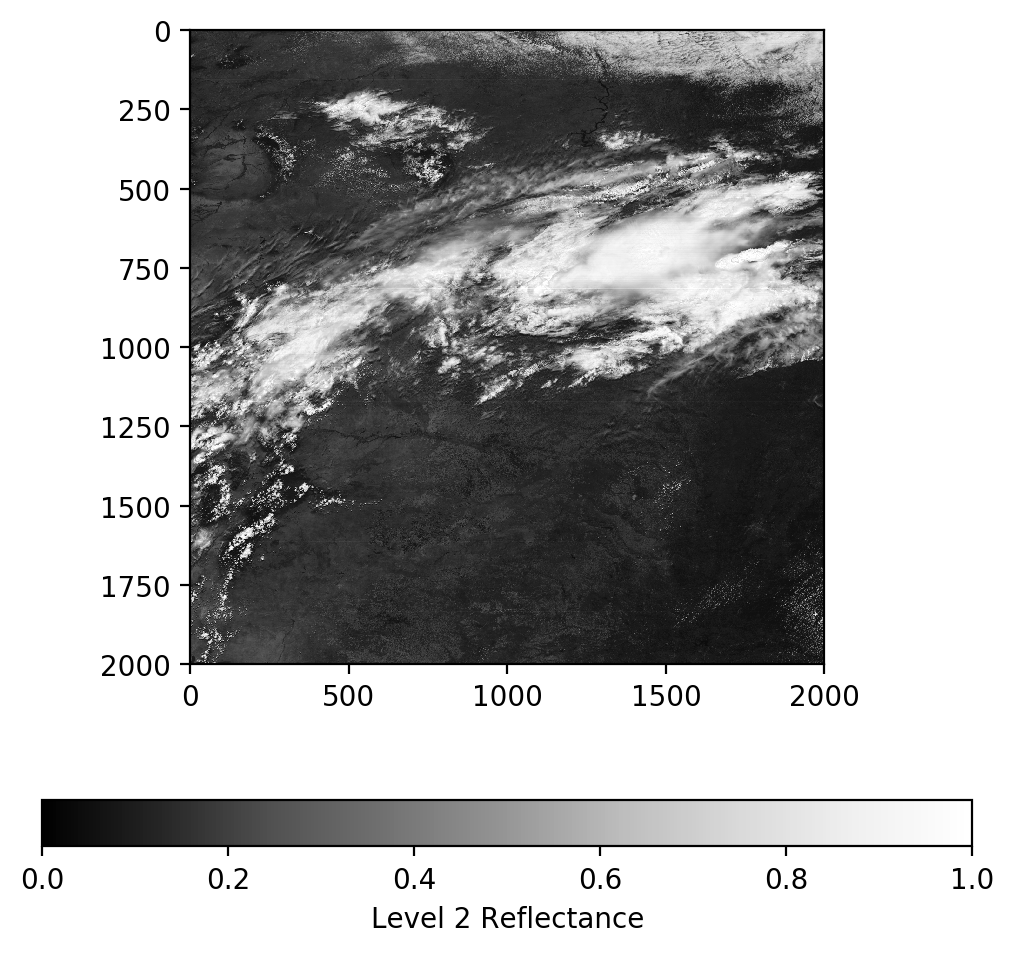

In [8]:
# Plot reflectance
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(ref_ch2, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Level 2 Reflectance')
plt.show()

As you can see, this looks very similar to what we computed but without all the work!

### Gamma correction
You'll notice the image above looks very dark, that is because the values are in linear units. We do a simple gamma correction to adjust this and brighten the image. This makes it easier to see features in the data.

In [9]:
# Apply the formula to adjust reflectance gamma
ref_gamma = np.sqrt(ref_ch2)

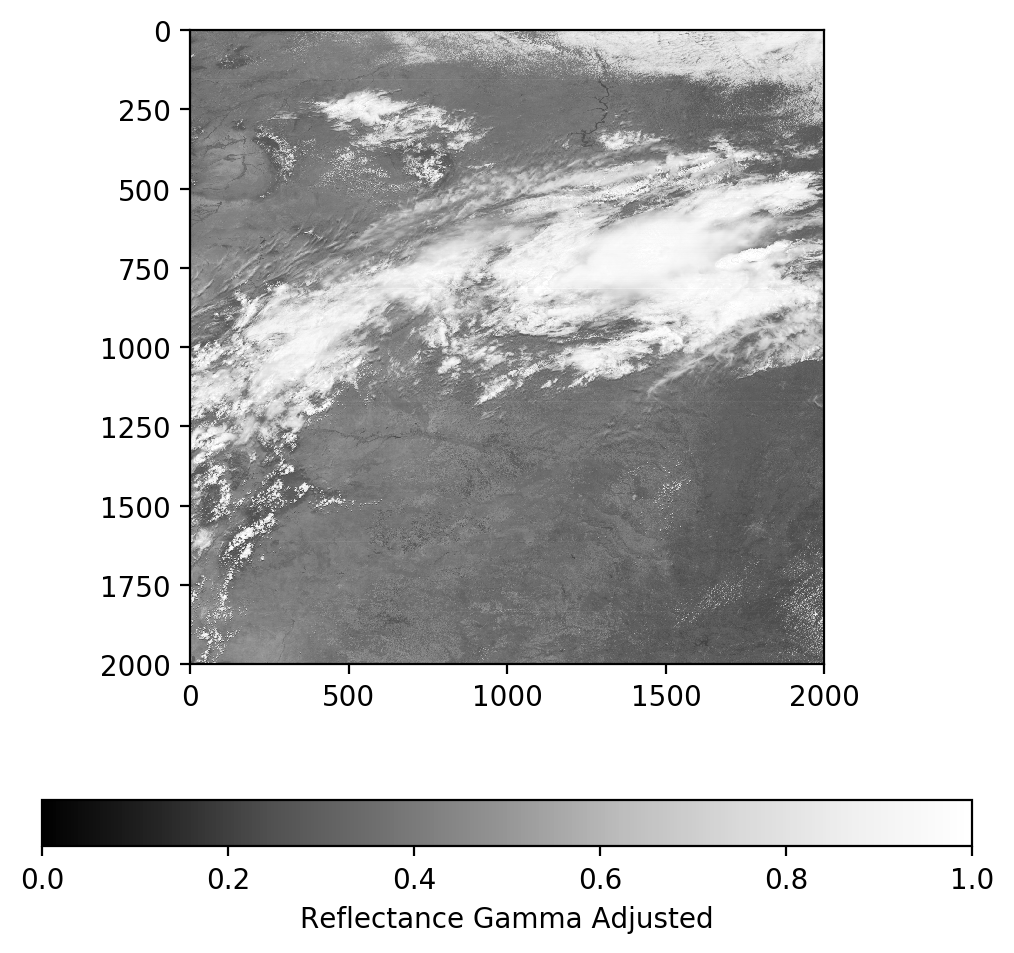

In [10]:
# Plot gamma adjusted reflectance
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(ref_gamma, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Reflectance Gamma Adjusted')
plt.show()

### Psuedo-True Color Image
GOES-16 Contains a Blue band and a Red band but no Green band. Fortunately, we can derive a linear relationship between the blue, red, and veggie (near IR) bands to approximate a green band. We will do that here.

In [11]:
# Load Channel 1 - Blue Visible & do gamma adjustment
g16nc = Dataset('OR_ABI-L2-CMIPM1-M3C01_G16_s20171931811268_e20171931811326_c20171931811382.nc', 'r')
ref_1 = g16nc.variables['CMI'][:]
g16nc.close()
g16nc = None
ref_gamma_1 = np.sqrt(ref_1)

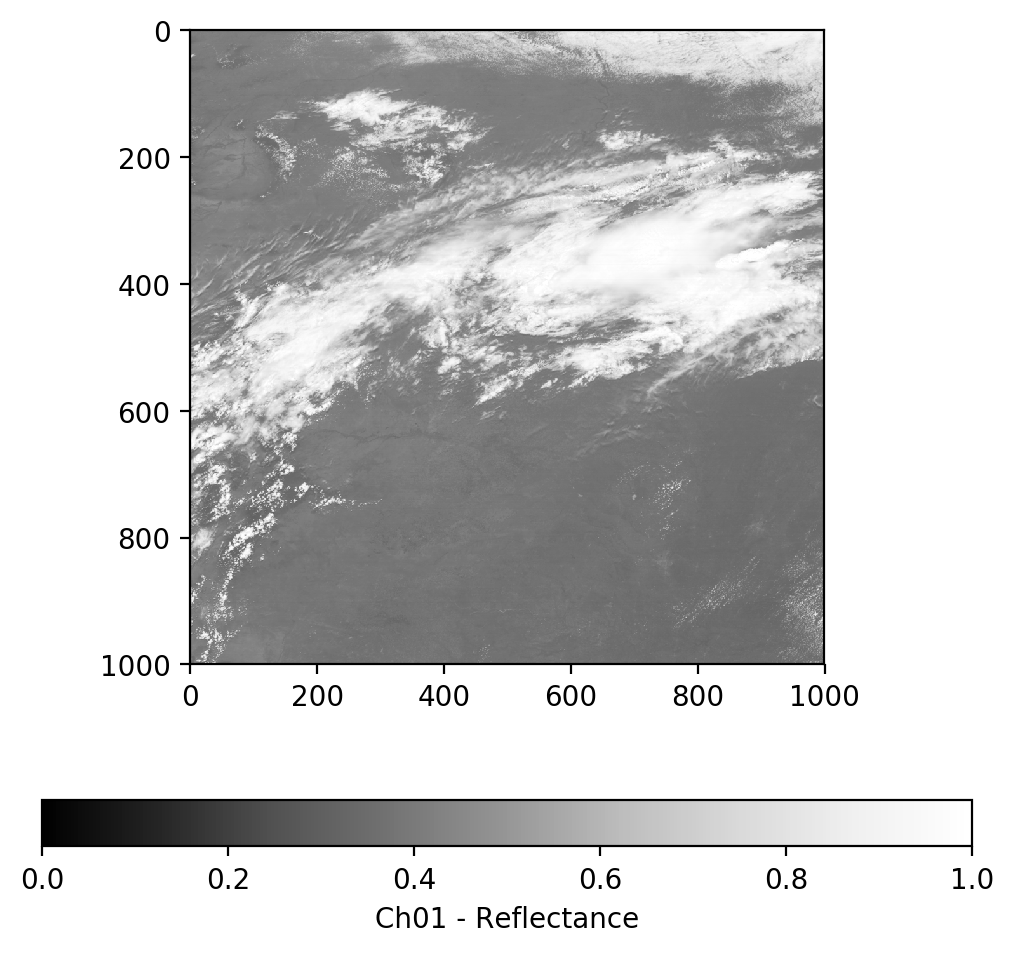

In [12]:
# Plot gamma adjusted reflectance channel 1
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(ref_gamma_1, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Ch01 - Reflectance')
plt.show()

In [13]:
# Load Channel 3 - Veggie Near IR & do gamma adjustment
g16nc = Dataset('OR_ABI-L2-CMIPM1-M3C03_G16_s20171931811268_e20171931811326_c20171931811389.nc', 'r')
ref_3 = g16nc.variables['CMI'][:]
g16nc.close()
g16nc = None
ref_gamma_3 = np.sqrt(ref_3)

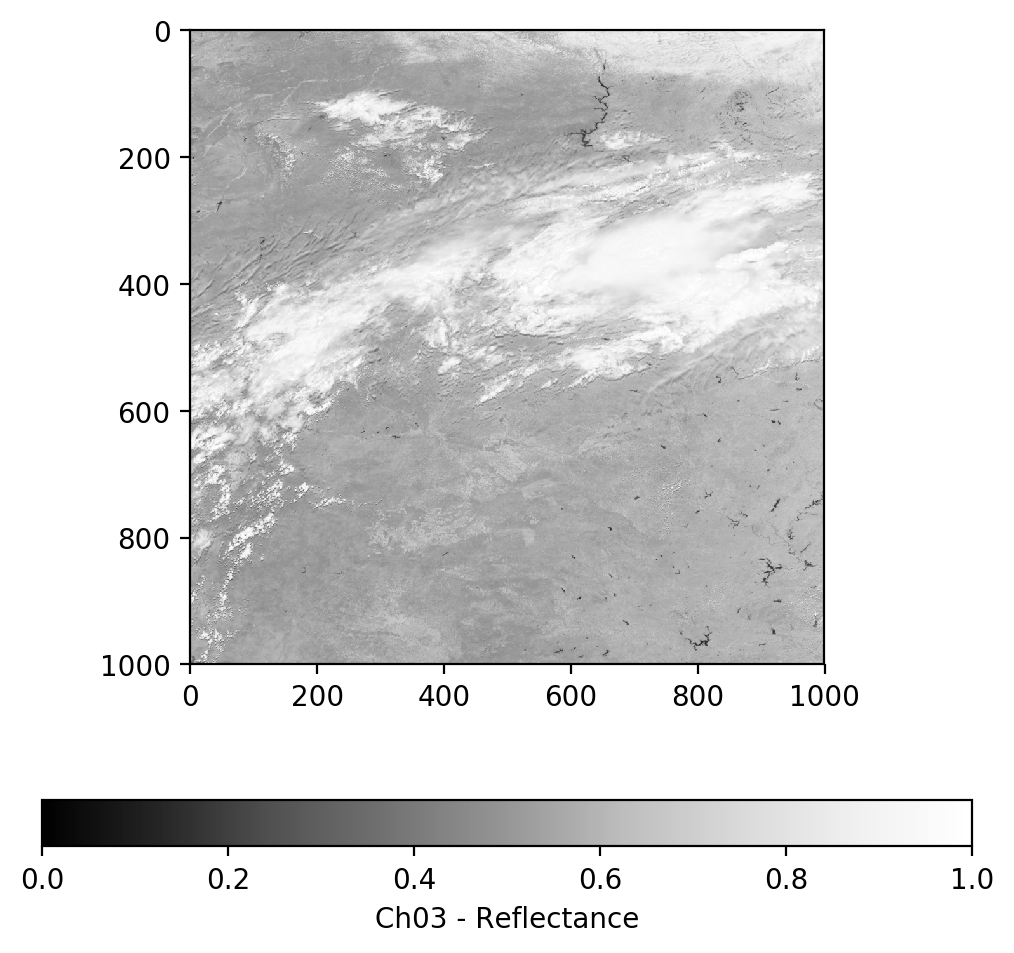

In [14]:
# Plot gamma adjusted reflectance channel 3
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(ref_gamma_3, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Ch03 - Reflectance')
plt.show()

On GOES-16, Band 2 (Red Visible) is 500-meter resolution while Band 1 (Blue Visible) and Band 3 (Veggie IR) are 1,000-meter resolution. In order to combine the 3 bands into an RGB image we will first resample bands 2 to 1000-meter resolution.

In [15]:
# Rebin function from https://stackoverflow.com/questions/8090229/resize-with-averaging-or-rebin-a-numpy-2d-array
def rebin(a, shape):
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [16]:
ref_gamma_2 = rebin(ref_gamma, [1000, 1000])

Lets make a geocolor image using the veggie near IR band directly in place of green and see how that looks.

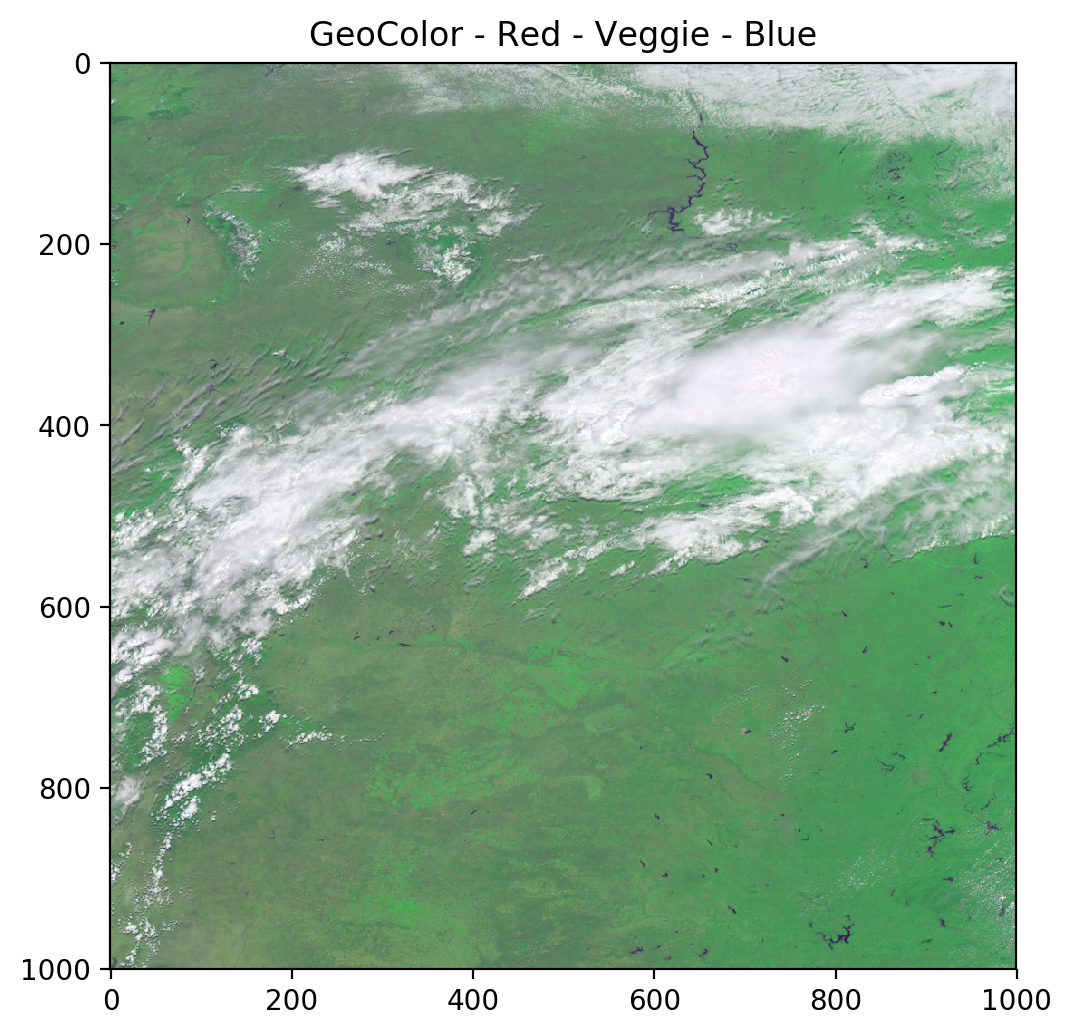

In [17]:
geocolor = np.stack([ref_gamma_2, ref_gamma_3, ref_gamma_1], axis=2)
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(geocolor)
plt.title('GeoColor - Red - Veggie - Blue')
plt.show()

As you can see, the green channel overpowers everything else. We will use a simple linear relationship to adjust the green values to create a psuedo-green channel and produce a better true color image.

In [18]:
# Derived from Planet Labs data, CC > 0.9
ref_gamma_true_green = 0.48358168 * ref_gamma_2 + 0.45706946 * ref_gamma_1 + 0.06038137 * ref_gamma_3

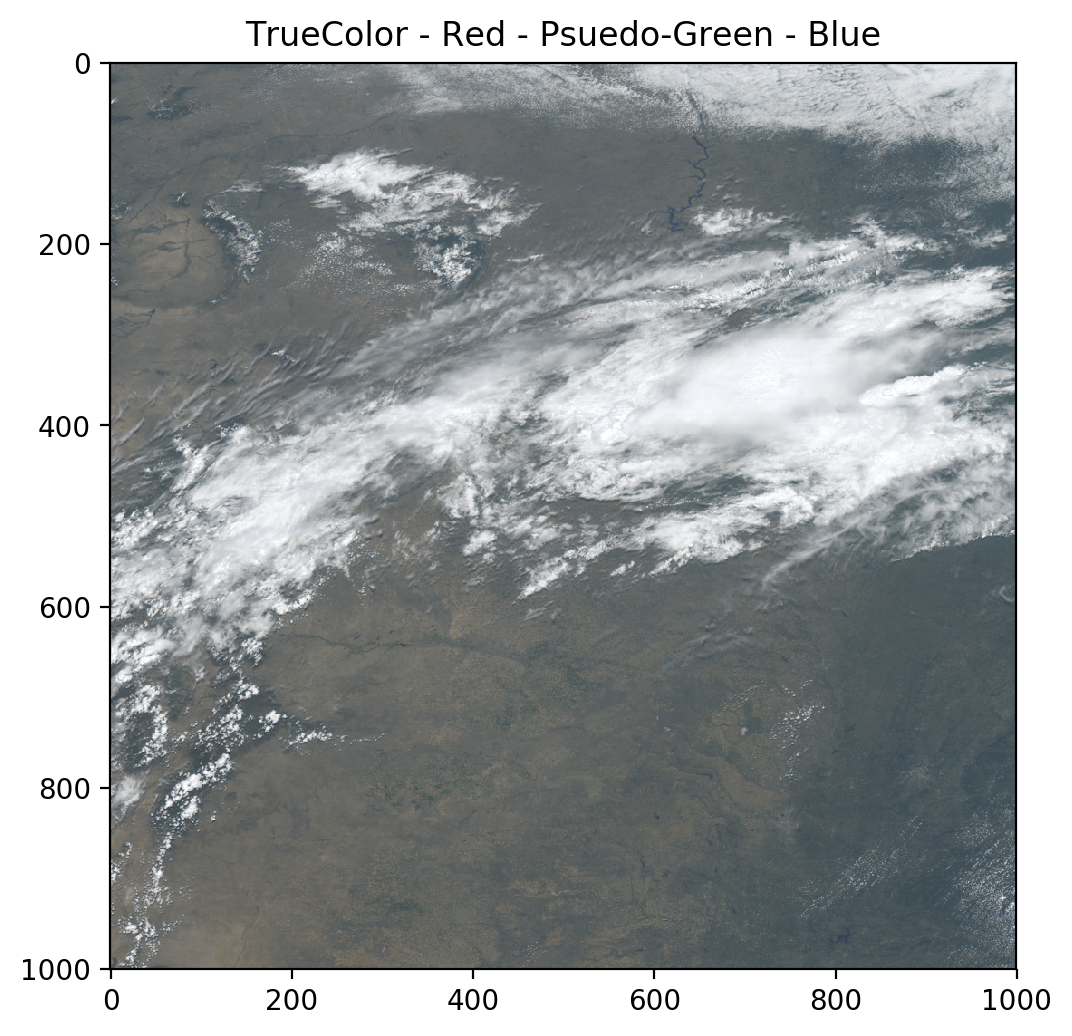

In [19]:
truecolor = np.stack([ref_gamma_2, ref_gamma_true_green, ref_gamma_1], axis=2)
fig = plt.figure(figsize=(6,6),dpi=200)
im = plt.imshow(truecolor)
plt.title('TrueColor - Red - Psuedo-Green - Blue')
plt.show()

Much better!